In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aksu-dataset/Aksu/Validation/Mask/GT_colored_11_26.tif
/kaggle/input/aksu-dataset/Aksu/Validation/Mask/GT_colored_14_31.tif
/kaggle/input/aksu-dataset/Aksu/Validation/Mask/GT_colored_25_26.tif
/kaggle/input/aksu-dataset/Aksu/Validation/Mask/GT_colored_21_27.tif
/kaggle/input/aksu-dataset/Aksu/Validation/Mask/GT_colored_15_03.tif
/kaggle/input/aksu-dataset/Aksu/Validation/Mask/GT_colored_07_17.tif
/kaggle/input/aksu-dataset/Aksu/Validation/Mask/GT_colored_16_02.tif
/kaggle/input/aksu-dataset/Aksu/Validation/Mask/GT_colored_14_26.tif
/kaggle/input/aksu-dataset/Aksu/Validation/Mask/GT_colored_19_09.tif
/kaggle/input/aksu-dataset/Aksu/Validation/Mask/GT_colored_16_20.tif
/kaggle/input/aksu-dataset/Aksu/Validation/Mask/GT_colored_21_13.tif
/kaggle/input/aksu-dataset/Aksu/Validation/Mask/GT_colored_03_13.tif
/kaggle/input/aksu-dataset/Aksu/Validation/Mask/GT_colored_11_13.tif
/kaggle/input/aksu-dataset/Aksu/Validation/Mask/GT_colored_25_18.tif
/kaggle/input/aksu-dataset/Aksu/Va

In [6]:
!pip install segmentation-models-pytorch
!pip install albumentations
!pip install tqdm
!pip install segmentation_models_p
!pip install pytorch-toolbelt
!pip install --upgrade scikit-image tifffile
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16429 sha256=291c02740e1d55a6ebbb66cb7499369d83d40d229b1e6b8dd37b87a364cdd7d5
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=07852846fc04109501db3d99ea57bdf2ba8612a84ce0d21e03d42794b10c5814
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release o

In [7]:
import os
import sys
import numpy as np
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn

from segmentation_models_pytorch.utils.train import TrainEpoch, ValidEpoch

import segmentation_models_pytorch.metrics
import tifffile
import albumentations as A
from matplotlib import pyplot as plt
import skimage.io
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import random
sys.path.append("..") 

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score

import tqdm

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [8]:
palette ={ 0 : (0,0,0),  #no data
           1 : (128, 255, 0), #forest -
           2 : (166, 0, 204), #mine-
           3 : (204, 0, 0), #road-
           4 : (255, 0, 0), #disc urban   -
           5 : (255, 255, 168), #arable land-
           6 : (255,230,166), #heteregonous agricultural areas -
           7 : (231, 40, 252), #permenant crops -
           8 : (0, 204, 242),  #inland waters -
           9 : (255, 166, 255),  #artificial non-agricultural vegetated areas-
         }

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

# helper function for data visualization
def visualize_in_one_row(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
def scale_range(input, min, max):
    input += -(np.min(input))
    input /= (1e-9 + np.max(input) / (max - min + 1e-9))
    input += min
    return input

def show_image(im,target_file): #PCG
      if len(im.shape) == 2:
        im = scale_range(im, 0, 255).astype(np.uint8)
        plt.figure(figsize=(16, 16), dpi= 80, facecolor='w', edgecolor='k')
        plt.imshow(im,cmap='gray')
        plt.show()

      elif len(im.shape) == 3:
        im = np.array([scale_range(i, 0, 255) for i in im.transpose((2,0,1))]).transpose(1,2,0)[...,:3].astype(np.uint8)
        plt.figure(figsize=(16, 16), dpi= 80, facecolor='w', edgecolor='k')
        plt.savefig(target_file, format = 'png', dpi =80,  transparent = True, bbox_inches = 'tight', pad_inches = 0)
        plt.imshow(im)
        plt.show()

def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
def evaluate(model, generator):
    """ usage:
        from sklearn.metrics import classification_report
        y_pred, y = evaluate(best_model, generator)
        y_pred  = np.hstack(y_pred)
        y = np.hstack(y)
        targets = ['building', 'not_building']
        print(classification_report(y, y_pred, target_names = targets))#, output_dict = True)
    """
    
    best_model = model
    best_model.cuda()
    best_model.eval()

    y_preds = list()
    ys = list()
    with torch.no_grad():
        for idx in tqdm.tqdm(range(len(generator))):
            X,y = generator[idx]
            #X = X.detach().cpu().numpy()
            y = y.detach().cpu().numpy()
            gt_max = np.argmax(y, axis=0)
            #gt_colora = convert_to_color(gt_max)
            logsoftmax = best_model.forward(X[None,:,:])
            y_pred = logsoftmax.argmax(dim=1)
            y_pred = y_pred.squeeze()
            gt_color = torch.as_tensor(gt_max).cuda()
            gt_color = gt_color.detach().cpu().numpy().flatten()
            y= gt_color 
            y_pred = y_pred.flatten().detach().cpu().numpy()
            
            ys.append(y)
            y_preds.append(y_pred)
            
    best_model.cpu()
    return y_preds, ys    
    
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    out = torch.utils.data.dataloader.default_collate(batch)
    print("len batch",len(out))
    return out

Class_names = ['NoData',
               'Forest',
               'Mine, dump and construction sites',
                'Road and Rail',
                'Discontinious Urban Fabric',
               'Arable Land',
               'Heterogeneous agricultural areas',
                'Permenant Crops',
                'Inland Waters',
                'Artificial, non-agricultural vegetated areas'] 

In [9]:
def _compute_stats_for_image(file_path: str) -> (np.ndarray, np.ndarray):

        image = skimage.io.imread(file_path, plugin='tifffile')

        mean = image.mean((0, 1))
        std = image.std((0, 1))

        assert mean.shape == (4,), f'mean had shape {mean.shape}'
        assert std.shape == (4,), f'std had shape {std.shape}'

        return mean, std


def _compute_stats_for_dir(dir_name) -> ([np.ndarray], [np.ndarray]):
    if not os.path.isdir(dir_name):
        raise ValueError(f'Directory does not exist: {dir}')

    means = []
    stds = []

    for dir_path, _, file_names in os.walk(dir_name):
        for file_name in file_names:
            mean, std = _compute_stats_for_image(os.path.join(dir_path, file_name))
            means.append(mean)
            stds.append(std)

    return means, stds

from PIL import Image
means, stds = _compute_stats_for_dir(r"/kaggle/input/aksu-dataset/Aksu/Train/Image")

mean_= np.asarray(means) 
mean__ = mean_[~np.isnan(mean_).any(axis=1)]
mean_mean = np.mean(mean__, axis = 0)

stds_ = np.asarray(stds) 
stds__ = stds_[~np.isnan(stds_).any(axis=1)]
stds_mean = np.mean(stds__, axis = 0)
print("MEAN", mean_mean)
print("STD",stds_mean)


/tmp/ipykernel_13/3738751954.py:3: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  image = skimage.io.imread(file_path, plugin='tifffile')
/tmp/ipykernel_13/3738751954.py:3: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  image = skimage.io.imread(file_path, plugin='tifffile')
/tmp/ipykernel_13/3738751954.py:3: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, plea

MEAN [266.65080797 330.40768099 189.73433818 568.11525197]
STD [ 65.57325577 102.13128407  96.49269973 206.7230676 ]


/tmp/ipykernel_13/3738751954.py:3: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  image = skimage.io.imread(file_path, plugin='tifffile')
/tmp/ipykernel_13/3738751954.py:3: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  image = skimage.io.imread(file_path, plugin='tifffile')


In [10]:
#tiff 
from tifffile import TiffFile
class MM_Dataset(Dataset):  
    def __init__(
            self, 
            dataset_dir,
            mode,
            transform=None, 
            preprocessing=None,
            sample_ids = False):

        self.dataset_dir = dataset_dir
        self.transform = transform
        self.preprocessing = preprocessing
        self.class_values = np.arange(0,10,1)
        self.sample_ids = sample_ids
        
        if mode == 'train':
            
            self.train_dir = os.path.join(self.dataset_dir, 'Train')
            
            optic_dir = os.path.join(self.train_dir, 'Image')
            mask_dir = os.path.join(self.train_dir, 'Mask')
            
            self.optic_ids = sorted(os.listdir(optic_dir))
            self.mask_ids = sorted(os.listdir(mask_dir))

            self.optic_fps = [os.path.join(optic_dir, image_id) for image_id in self.optic_ids]
            self.mask_fps = [os.path.join(mask_dir, image_id) for image_id in self.mask_ids]
            print("Training set: {} image".format(len(self.optic_ids)))
            
        if mode == 'val':
            
            self.train_dir = os.path.join(self.dataset_dir, 'Validation')
            
            optic_dir = os.path.join(self.train_dir, 'Image')
            mask_dir = os.path.join(self.train_dir, 'Mask')
            
            self.optic_ids = sorted(os.listdir(optic_dir))
            self.mask_ids = sorted(os.listdir(mask_dir))

            self.optic_fps = [os.path.join(optic_dir, image_id) for image_id in self.optic_ids]
            self.mask_fps = [os.path.join(mask_dir, image_id) for image_id in self.mask_ids]
            print("Validation set: {} image".format(len(self.optic_ids)))
            
        elif mode == 'test':
            
            self.test_dir = os.path.join(self.dataset_dir, 'Test')
            
            optic_dir = os.path.join(self.test_dir, 'Image')
            mask_dir = os.path.join(self.test_dir, 'Mask')
            
            self.optic_ids = sorted(os.listdir(optic_dir))
            self.mask_ids = sorted(os.listdir(mask_dir))

            self.optic_fps = [os.path.join(optic_dir, image_id) for image_id in self.optic_ids]
            self.mask_fps = [os.path.join(mask_dir, image_id) for image_id in self.mask_ids]
            print("Test set: {} image".format(len(self.optic_ids)))

    @staticmethod
    
    def _read_img(image_path):
        try:
            with TiffFile(image_path) as tif:
                return tif.asarray()
        except Exception as e:
            print(f"Error reading {image_path}: {e}")
            return None

    def __len__(self):
        return len(self.mask_ids)
    
    def __getitem__(self, idx):

        optic_id = self.optic_fps[idx].split('\\')[-1]
        mask_id = self.mask_fps[idx].split('\\')[-1]

        optic_filepath = self.optic_fps[idx] 
        mask_filepath = self.mask_fps[idx]

        try:
            image = self._read_img(optic_filepath)
        except TiffFileError as e:
            print(f"Error reading {optic_filepath}: {e}")
            image = None
    
        mask = self._read_img(mask_filepath)
        mask = mask.astype('uint8')

        if image is None or mask is None:
            # Handle error case, return None
            return None

        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        if self.preprocessing:
            preprocessed = self.preprocessing(image=image, mask=mask)
            image, mask = preprocessed['image'], preprocessed['mask']

        mask_raw = convert_from_color(mask)

        masks = [(mask_raw == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1)

        image = image.transpose(2, 0, 1).astype('float32')
        mask = mask.transpose(2, 0, 1).astype('float32')

        image = torch.as_tensor(image, dtype=torch.float32)
        mask = torch.as_tensor(mask, dtype=torch.float32)
    
        if self.sample_ids is not False:
            return image, mask, optic_id

        return image, mask

In [11]:
#aksu
train_transform = A.Compose([
  A.PadIfNeeded(512,512),
  A.RandomRotate90(),
  A.Flip(),
  A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
  A.Normalize(mean=[279, 345, 199, 592], std=[59, 95, 93, 200]) 
])

val_transform = A.Compose([
  A.PadIfNeeded(512, 512),
  A.Normalize(mean=[279, 345, 199, 592], std=[59, 95, 93, 200])  
])

test_transform = A.Compose([
  A.PadIfNeeded(512, 512), 
  A.Normalize(mean=[279, 345, 199, 592], std=[59, 95, 93, 200])
])




/tmp/ipykernel_13/1302630614.py:5: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  A.Flip(),


In [12]:
SEED = 33
seed_everything(SEED)
# dataset_dir = r"/kaggle/input/major-project-dataset/Aksu-20240906T085209Z-001/Aksu"
dataset_dir =r"/kaggle/input/aksu-dataset/Aksu"

Training set: 419 image
Validation set: 120 image
Test set: 60 image


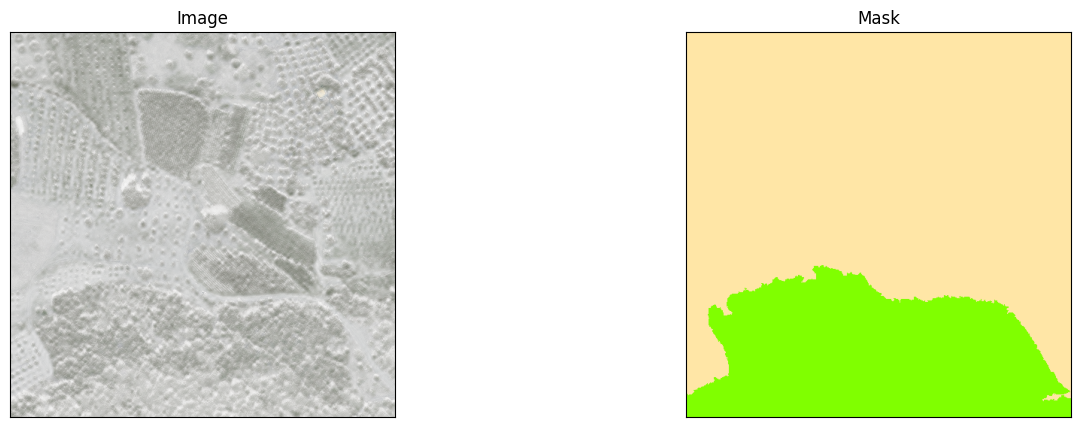

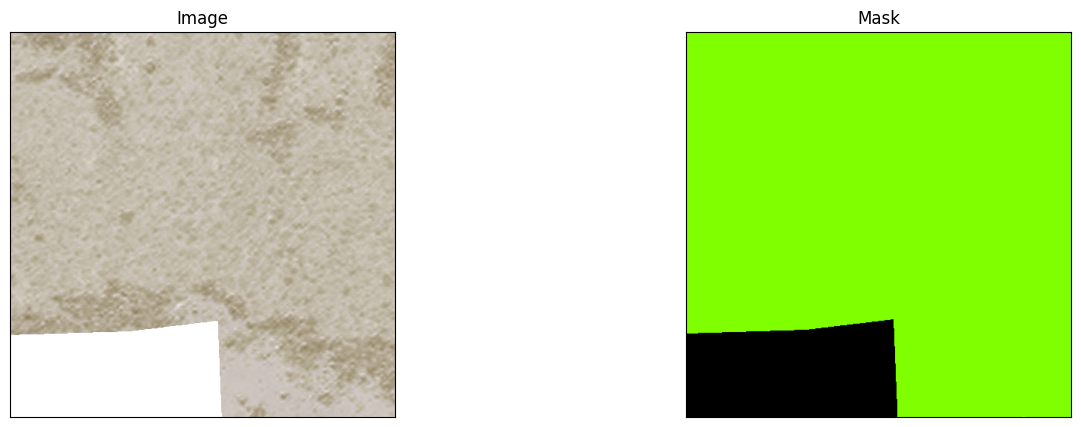

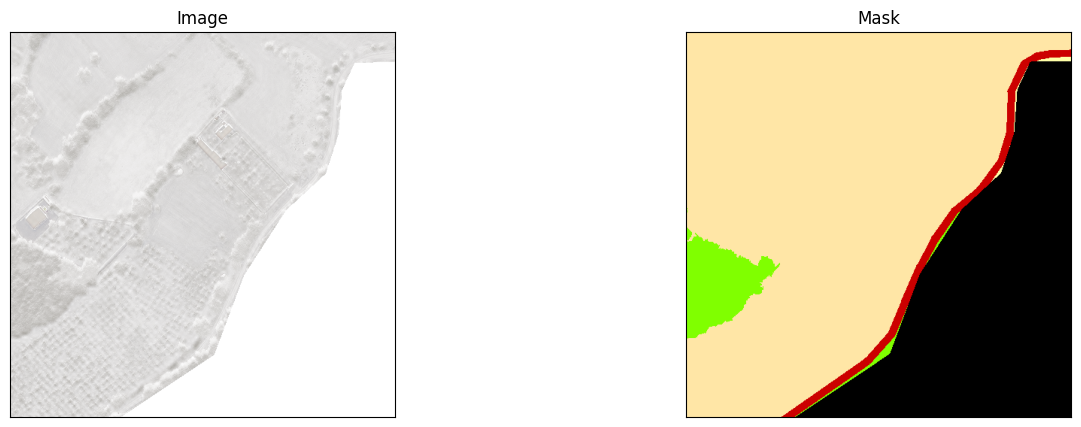

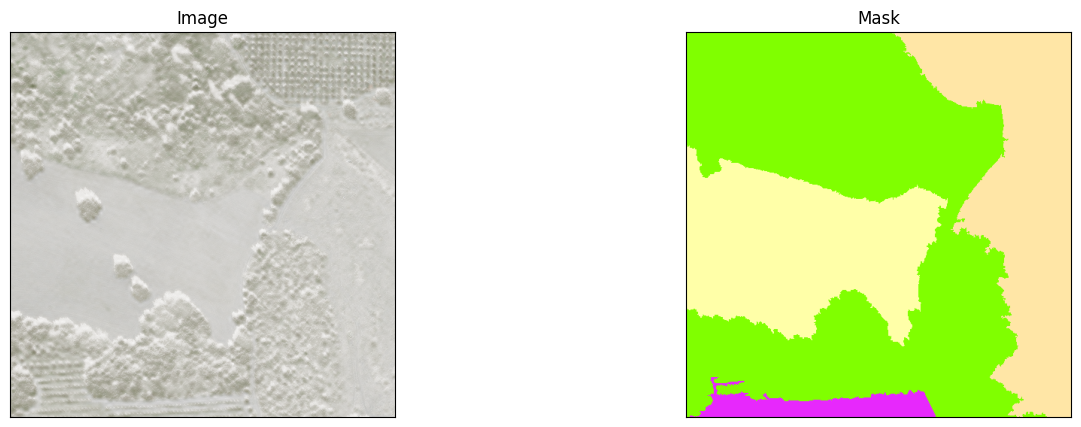

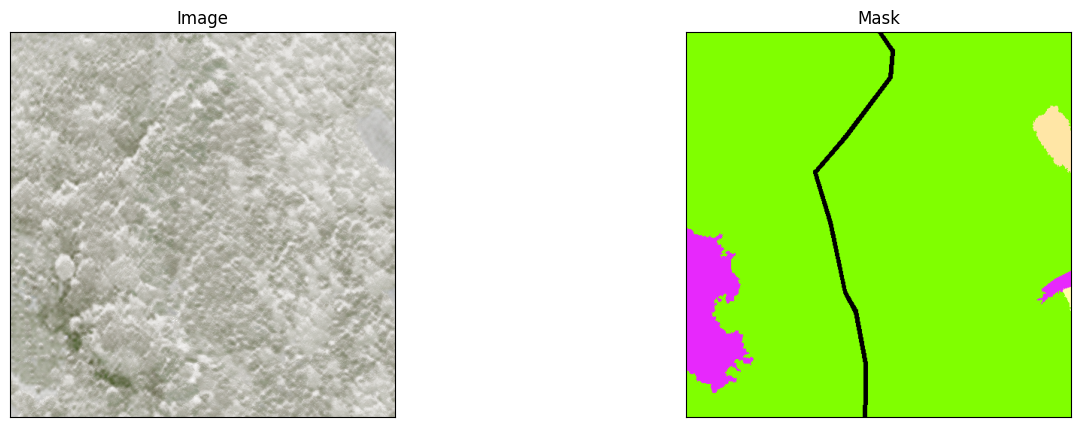

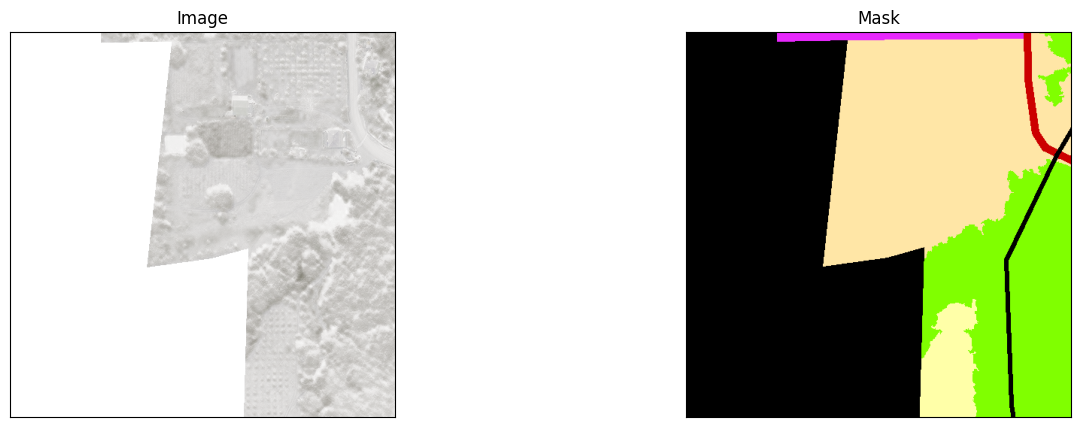

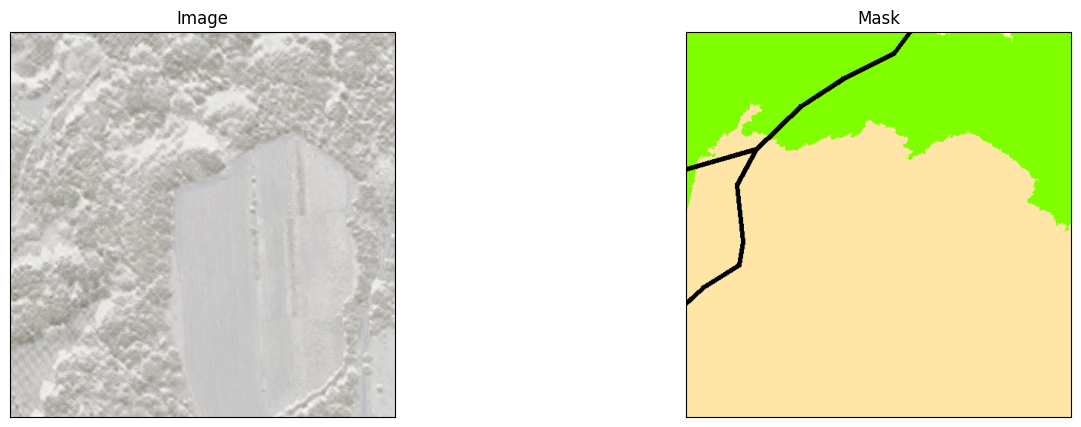

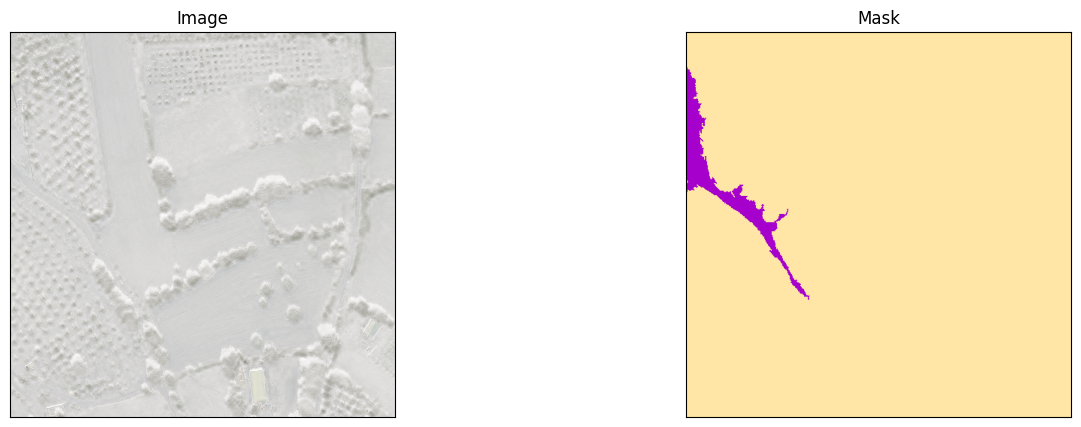

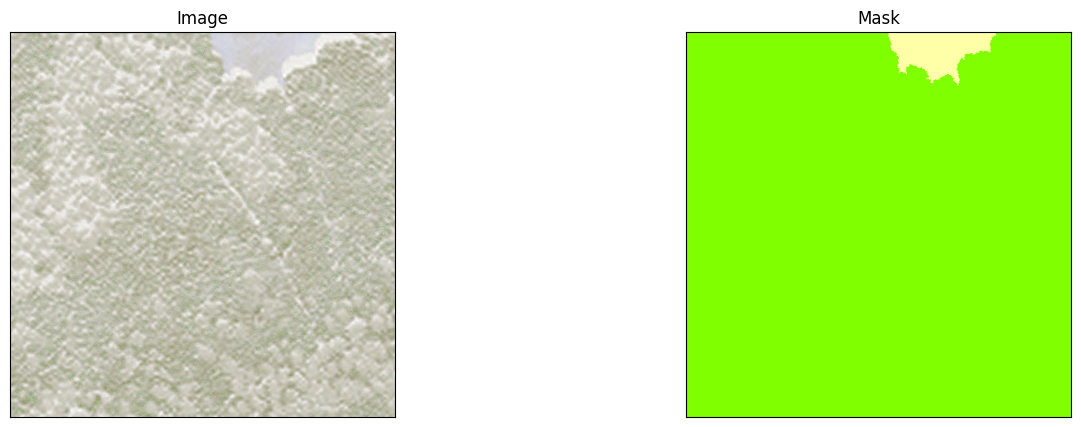

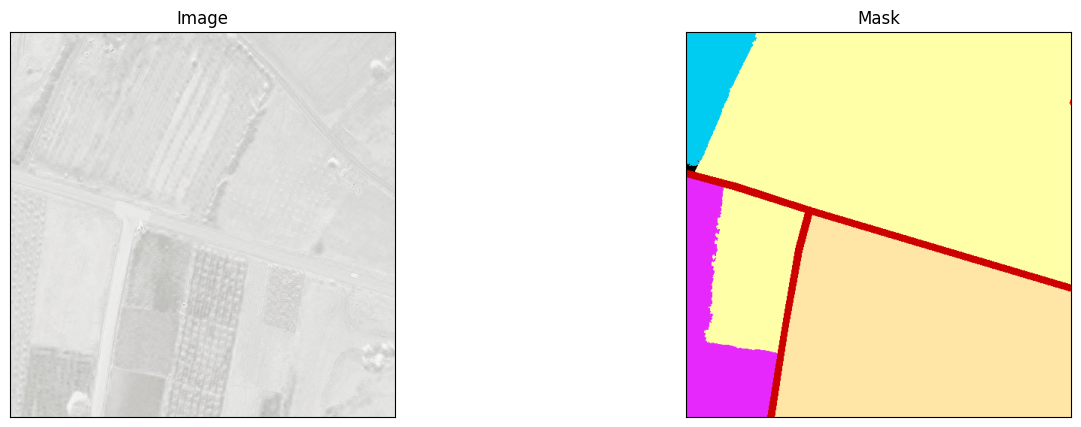

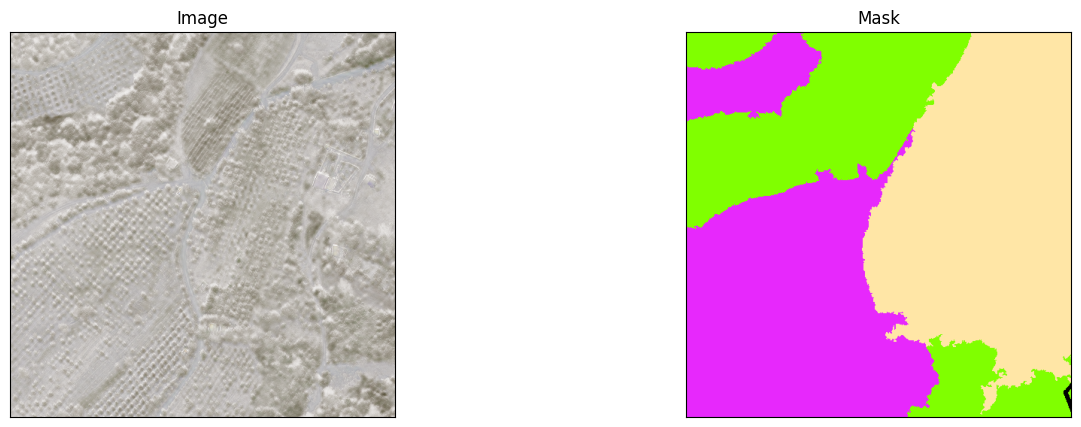

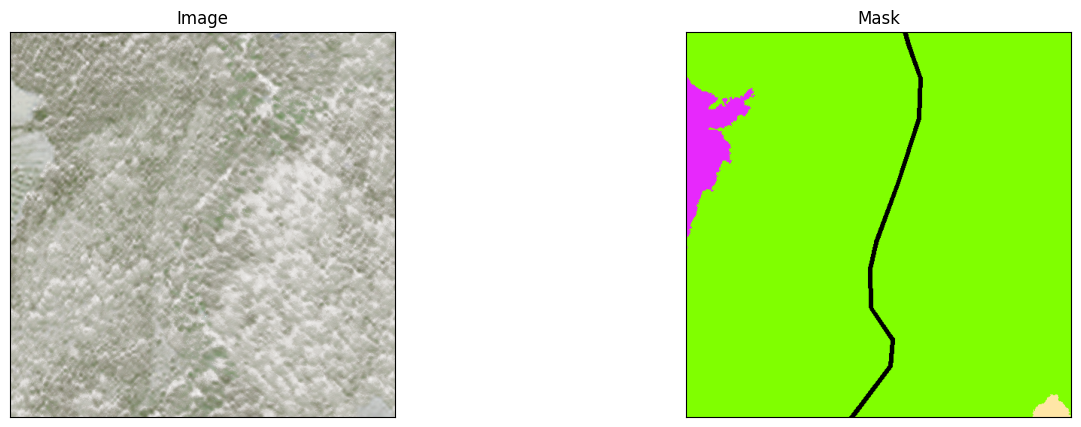

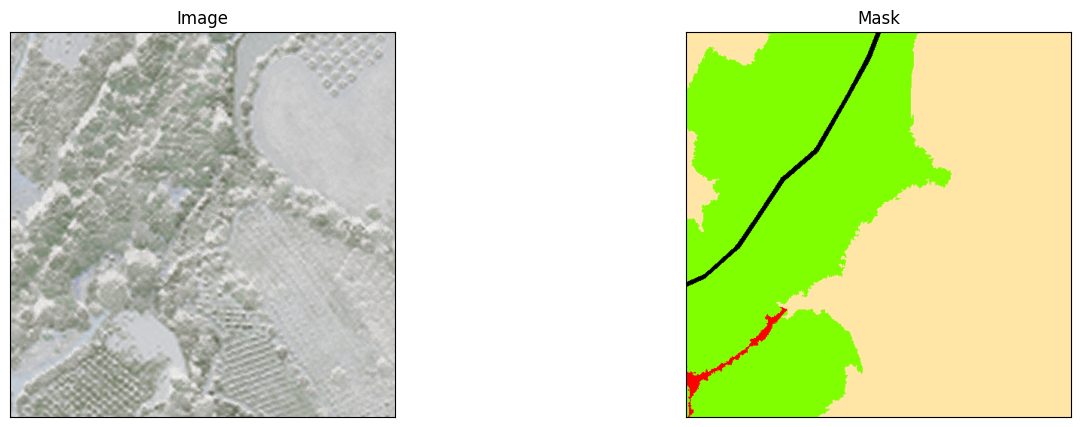

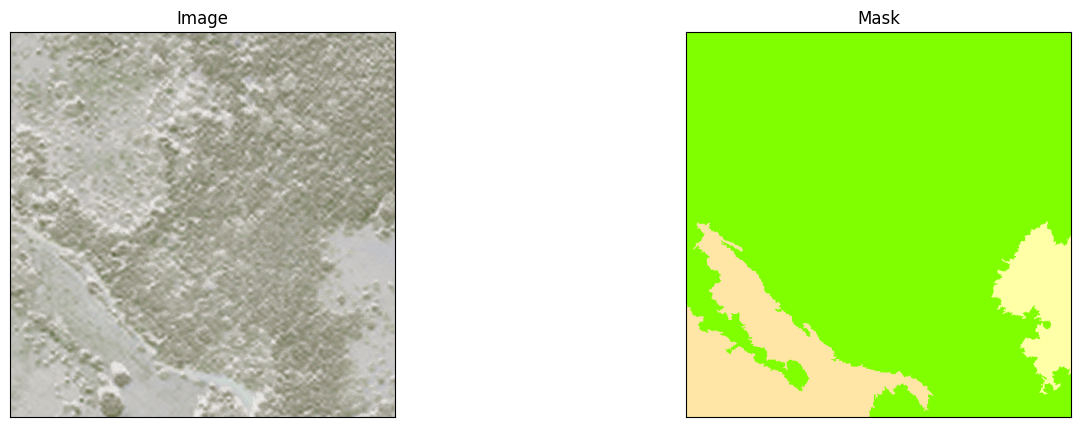

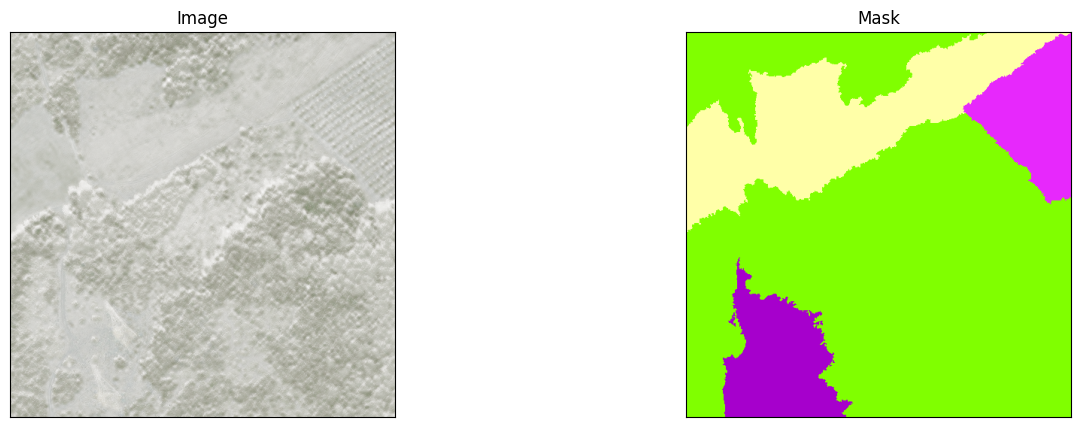

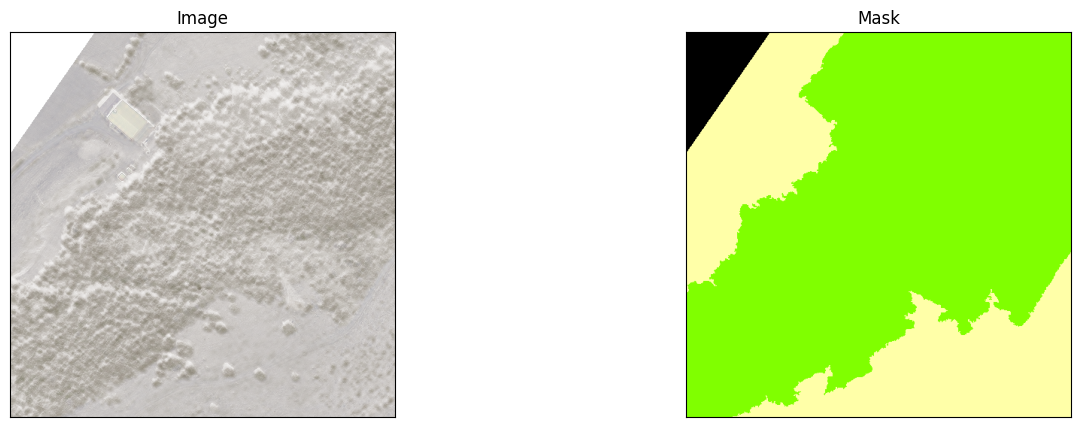

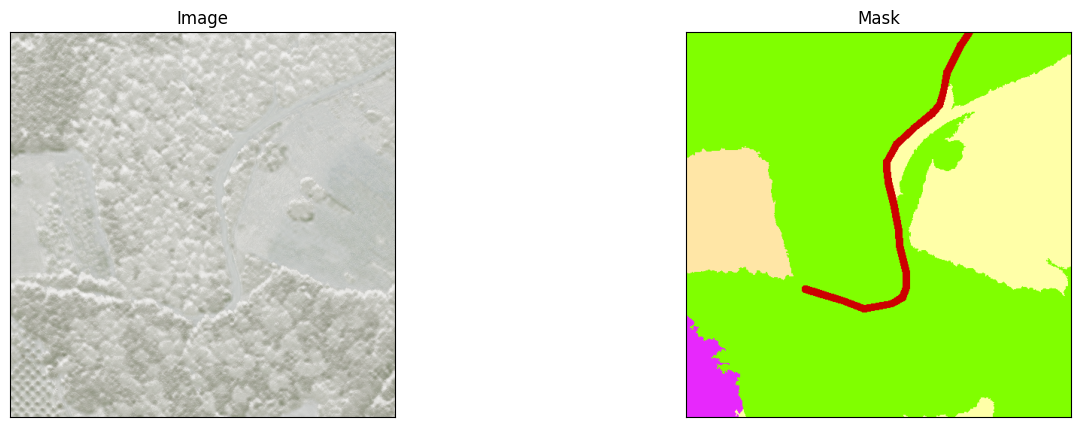

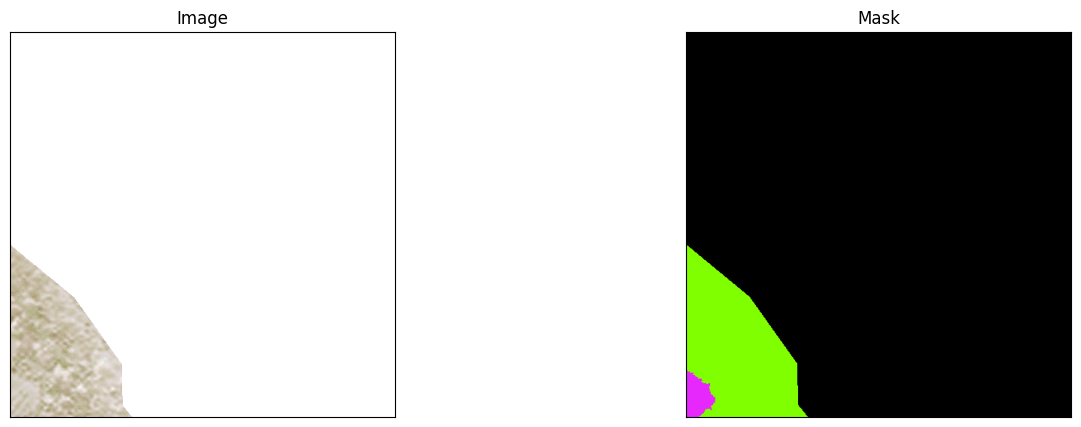

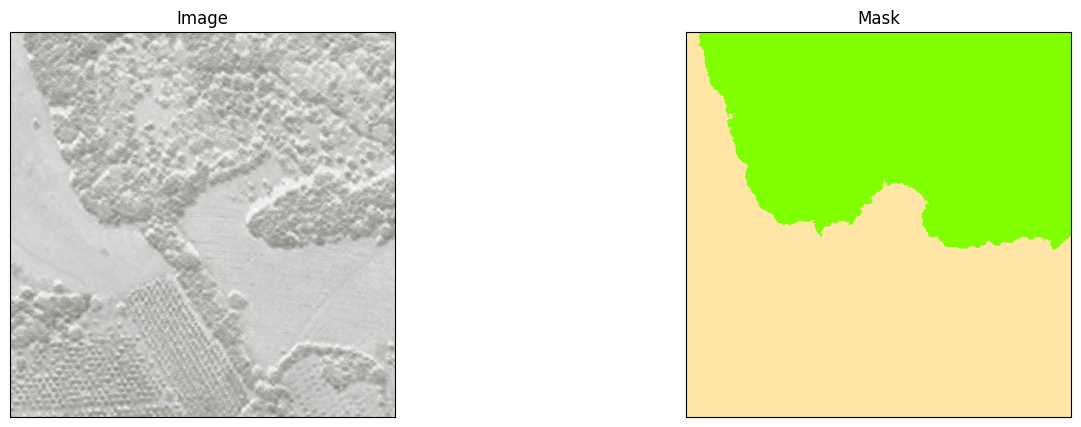

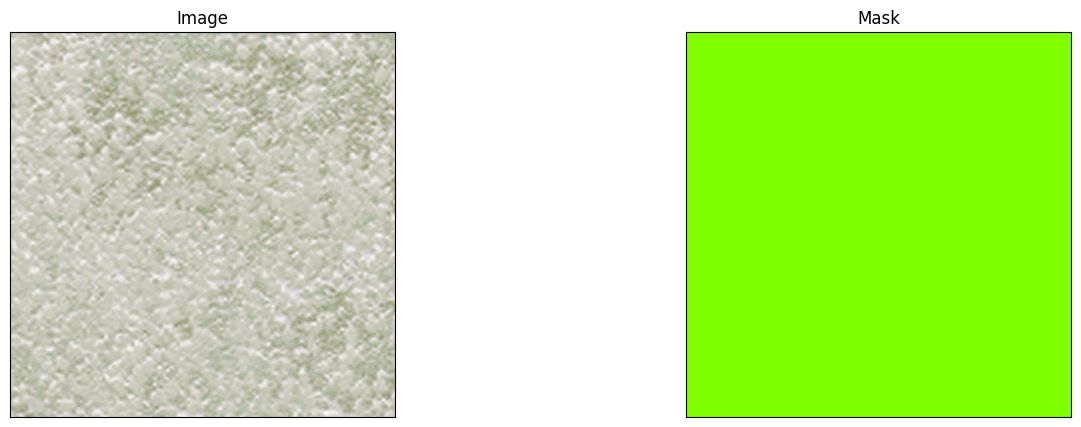

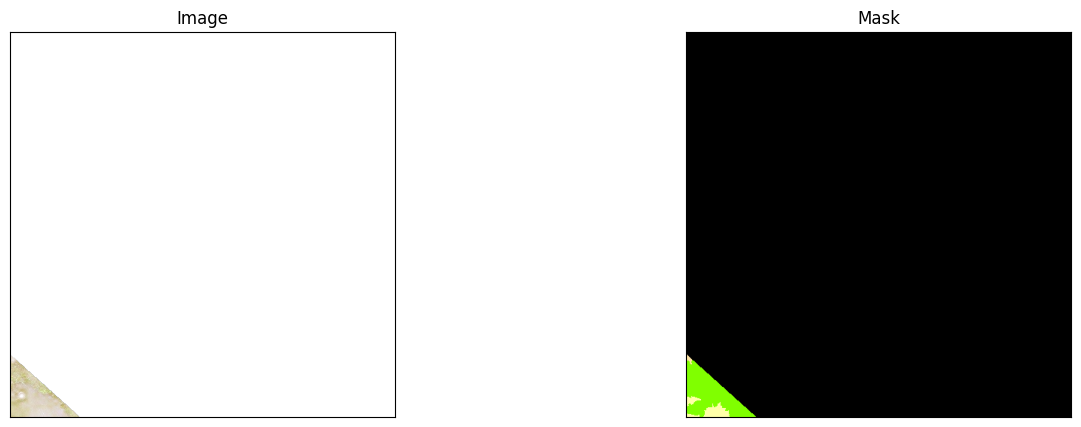

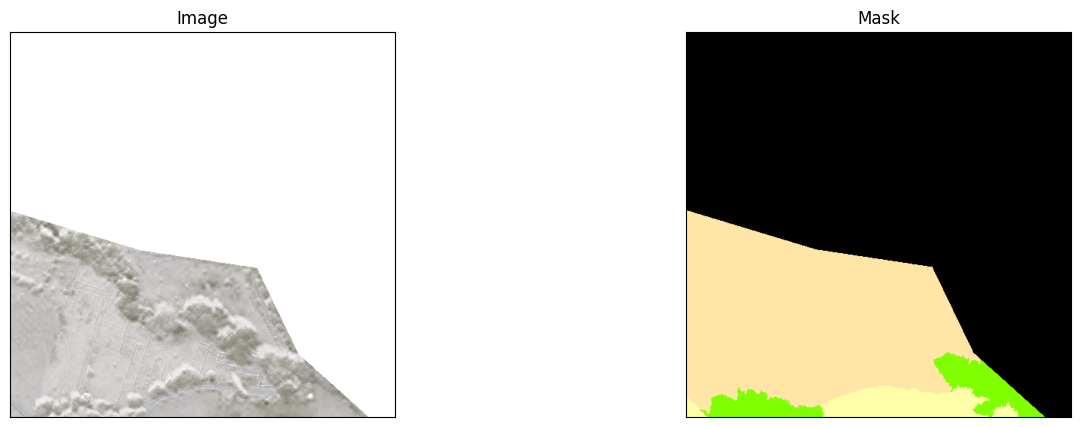

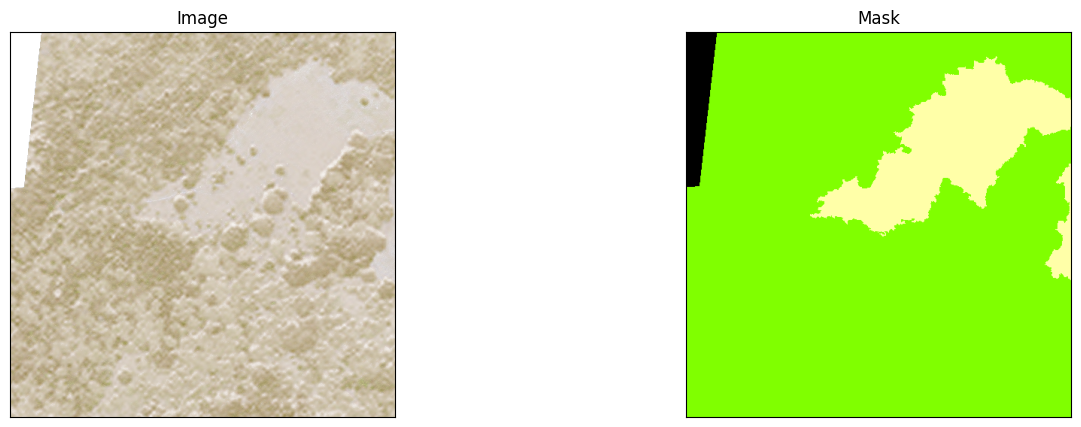

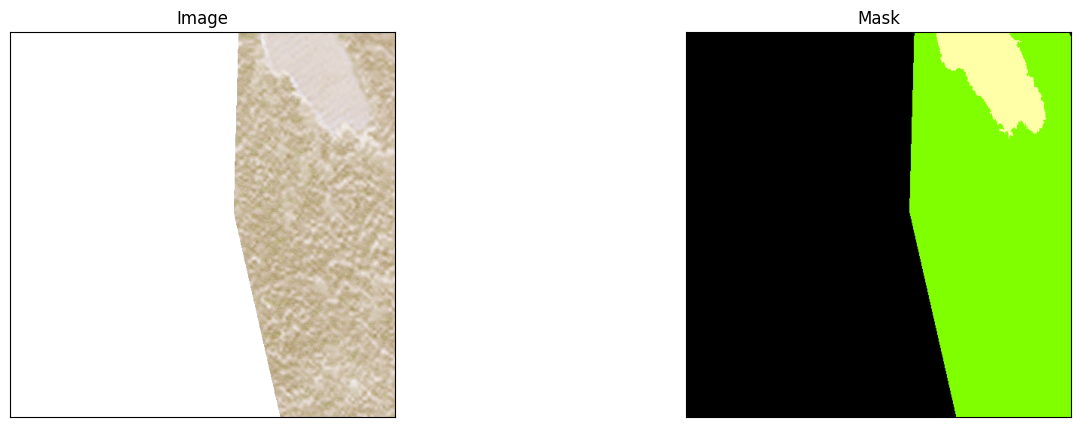

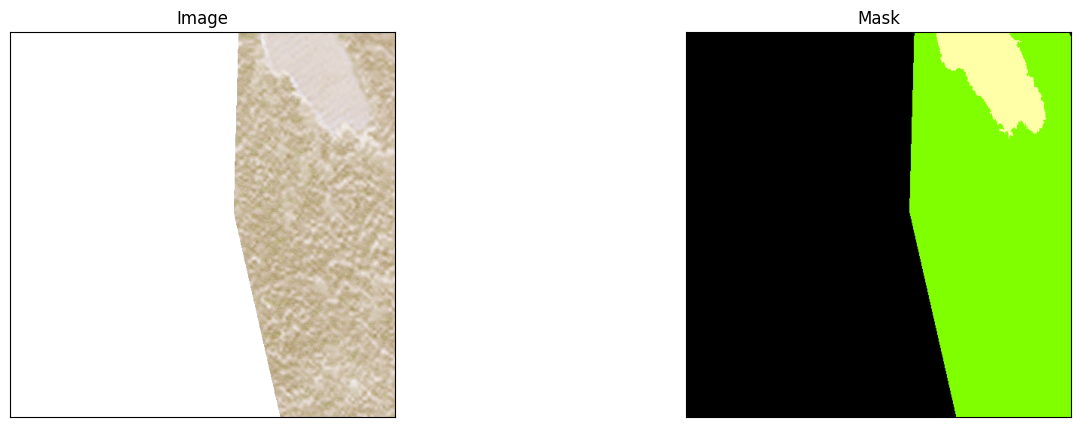

In [13]:
train_dataset = MM_Dataset(dataset_dir = dataset_dir,
                    mode='train',
                    transform = train_transform)

val_dataset = MM_Dataset(dataset_dir = dataset_dir,
                    mode='val',
                    transform = val_transform)

test_dataset = MM_Dataset(dataset_dir = dataset_dir,
                    mode='test',
                    transform = test_transform)

#SAMPLING TECHNIQUES
from sklearn.utils import compute_sample_weight
from pytorch_toolbelt.utils import fs
from torch.utils.data import WeightedRandomSampler

def get_balanced_weights(dataset):
    labels=[]
    for mask in dataset.mask_fps:
        mask = fs.read_image_as_is(mask)
        unique_labels = np.unique(mask)
        labels.append(''.join([str(int(i)) for i in unique_labels]))

    weights = compute_sample_weight('balanced', labels)
    return weights

mul_factor =  5
train_sampler = WeightedRandomSampler(get_balanced_weights(train_dataset), len(train_dataset) * mul_factor)
val_sampler = WeightedRandomSampler(get_balanced_weights(val_dataset), len(val_dataset) * mul_factor)


#SANITY CHECK
for i in range(25):

    idx = np.random.randint(0,len(val_dataset))
    image, mask = val_dataset[idx]

    im = image.detach().cpu().numpy()
    image = np.transpose(im, (1,2,0))

    # Check for invalid values
    if np.any(np.isnan(image)) or np.any(np.isinf(image)):
        print("Found NaN or inf! Filtering...")
        image[np.isnan(image)] = 0
        image[np.isinf(image)] = 0

    # Normalize each channel independently
    image = image.astype('float32')
    image -= image.min(axis=(0,1), keepdims=True)
    
    # Avoid divide by zero 
    image /= (image.max(axis=(0,1), keepdims=True) + 1e-7)
    
    # Clip values before casting to uint8
    image *= 255
    image = np.clip(image, 0, 255).astype('uint8')

    mask = mask.detach().cpu().numpy()
    gt_mask = np.transpose(mask, (1,2,0))
    gt_max = np.argmax(gt_mask, axis=-1)
    gt_color = convert_to_color(gt_max)

    visualize_in_one_row(Image=image,  
                         Mask=gt_color)

In [14]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import cv2
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ✅ Ensure MM_Dataset and FlipCAM are properly defined


In [15]:
# class MM_Dataset(data.Dataset):
#     def __init__(self, dataset_dir, mode="train", transform=None):
#         self.dataset_dir = dataset_dir
#         self.mode = mode
#         self.image_paths = []
#         self.labels = []
        
#         if transform is None:
#             self.transform = transforms.Compose([
#                 transforms.ToTensor(),
#                 transforms.Resize((224, 224)),  # Resize images for consistency
#                 transforms.Normalize(mean=[0.5], std=[0.5])
#             ])
#         else:
#             self.transform = transform

#         mode_path = os.path.join(self.dataset_dir, mode)
#         if not os.path.exists(mode_path):
#             raise FileNotFoundError(f"Dataset path not found: {mode_path}")

#         for class_name in sorted(os.listdir(mode_path)):
#             class_dir = os.path.join(mode_path, class_name)
#             if os.path.isdir(class_dir):
#                 for file_name in os.listdir(class_dir):
#                     file_path = os.path.join(class_dir, file_name)
#                     self.image_paths.append(file_path)
#                     self.labels.append(class_name)

#         self.label_to_idx = {label: idx for idx, label in enumerate(sorted(set(self.labels)))}
#         self.labels = [self.label_to_idx[label] for label in self.labels]

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         img_path = self.image_paths[idx]
#         label = self.labels[idx]

#         # ✅ Use OpenCV to handle TIFF images
#         image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
#         if image is None:
#             raise RuntimeError(f"Error reading image: {img_path}")

#         if len(image.shape) == 2:
#             image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
#         else:
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         image = self.transform(image)

#         return image, label

import os
import cv2
import torch
import numpy as np
from torch.utils import data
from torchvision import transforms

class MM_Dataset(data.Dataset):
    def __init__(self, dataset_dir, mode="train", transform=None):
        self.dataset_dir = dataset_dir
        self.mode = mode
        self.image_paths = []
        self.labels = []

        # Default transformation pipeline
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor(),  
                transforms.Resize((224, 224)),  # Ensure consistent size
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize RGB channels
            ])
        else:
            self.transform = transform

        # Validate mode path
        mode_path = os.path.join(self.dataset_dir, mode)
        if not os.path.exists(mode_path):
            raise FileNotFoundError(f"Dataset path not found: {mode_path}")

        # Load image paths and labels
        for class_name in sorted(os.listdir(mode_path)):
            class_dir = os.path.join(mode_path, class_name)
            if os.path.isdir(class_dir):
                for file_name in os.listdir(class_dir):
                    file_path = os.path.join(class_dir, file_name)
                    self.image_paths.append(file_path)
                    self.labels.append(class_name)

        # Map labels to numerical indices
        self.label_to_idx = {label: idx for idx, label in enumerate(sorted(set(self.labels)))}
        self.labels = [self.label_to_idx[label] for label in self.labels]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load the image using OpenCV
        image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        if image is None:
            raise RuntimeError(f"Error reading image: {img_path}")

        # Convert grayscale to RGB if necessary
        if len(image.shape) == 2:  
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        elif image.shape[-1] == 4:  # Handle RGBA images (e.g., some TIFFs)
            image = image[:, :, :3]  # Drop alpha channel

        # Normalize to [0,1] range before converting to tensor
        if image.dtype == np.uint16:
            image = image.astype(np.float32) / 65535.0  # Normalize 16-bit images
        else:
            image = image.astype(np.float32) / 255.0  # Normalize 8-bit images

        # Apply transformations
        image = self.transform(image)

        return image, label


In [16]:
class FlipCAM(nn.Module):
    def __init__(self, num_classes):
        super(FlipCAM, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)  # Assuming input size 224x224
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [17]:
dataset_dir = "/kaggle/input/aksu-dataset/Aksu"

train_dataset = MM_Dataset(dataset_dir=dataset_dir, mode="Train")
val_dataset = MM_Dataset(dataset_dir=dataset_dir, mode="Validation")
test_dataset = MM_Dataset(dataset_dir=dataset_dir, mode="Test")

train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)



In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.label_to_idx)
model = FlipCAM(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Function
def train_model(model, train_loader, val_loader, epochs=5):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        acc = accuracy_score(all_labels, all_preds)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}, Accuracy: {acc:.4f}")

# Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted", zero_division=1)
    recall = recall_score(all_labels, all_preds, average="weighted", zero_division=1)
    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=1)

    print(f"Test - Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# Train and Evaluate
train_model(model, train_loader, val_loader, epochs=10)
evaluate_model(model, test_loader)


Epoch 1/10, Loss: 50.7353, Accuracy: 0.9165
Epoch 2/10, Loss: 13.9740, Accuracy: 0.9666
Epoch 3/10, Loss: 6.4639, Accuracy: 0.9940
Epoch 4/10, Loss: 0.7888, Accuracy: 0.9976
Epoch 5/10, Loss: 0.0114, Accuracy: 1.0000
Epoch 6/10, Loss: 0.0026, Accuracy: 1.0000
Epoch 7/10, Loss: 0.0011, Accuracy: 1.0000
Epoch 8/10, Loss: 0.0007, Accuracy: 1.0000
Epoch 9/10, Loss: 0.0006, Accuracy: 1.0000
Epoch 10/10, Loss: 0.0004, Accuracy: 1.0000
Test - Accuracy: 0.9917, Precision: 0.9918, Recall: 0.9917, F1-score: 0.9917


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TCBlock(nn.Module):
    """Truncation Compensation Block with multi-scale feature fusion."""
    def __init__(self, in_channels, out_channels):
        super(TCBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        out = self.bn(x3 + x)  # Skip connection for compensation
        return self.relu(out)

class TCNet(nn.Module):
    """Truncation Compensation Network for segmentation."""
    def __init__(self, num_classes):
        super(TCNet, self).__init__()
        
        # Encoder (Feature Extraction)
        self.encoder1 = TCBlock(4, 64)  # 4 Channels (RGB+NIR)
        self.encoder2 = TCBlock(64, 128)
        self.encoder3 = TCBlock(128, 256)

        # Bottleneck
        self.bottleneck = TCBlock(256, 512)

        # Decoder (Upsampling)
        self.decoder3 = TCBlock(512, 256)
        self.decoder2 = TCBlock(256, 128)
        self.decoder1 = TCBlock(128, 64)

        # Final segmentation head
        self.segmentation_head = nn.Conv2d(64, num_classes, kernel_size=1)  

    def forward(self, x):
        # Encoding path
        e1 = self.encoder1(x)
        e2 = self.encoder2(F.max_pool2d(e1, kernel_size=2))
        e3 = self.encoder3(F.max_pool2d(e2, kernel_size=2))

        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e3, kernel_size=2))

        # Decoding path
        d3 = self.decoder3(F.interpolate(b, scale_factor=2, mode='bilinear', align_corners=True))
        d2 = self.decoder2(F.interpolate(d3 + e3, scale_factor=2, mode='bilinear', align_corners=True))
        d1 = self.decoder1(F.interpolate(d2 + e2, scale_factor=2, mode='bilinear', align_corners=True))

        # Output segmentation mask
        output = self.segmentation_head(d1 + e1)
        return torch.sigmoid(output)  # Binary segmentation

